In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import Any, Tuple

sns.set(style="whitegrid")

print('[+] Налаштування завершено')

[+] Налаштування завершено


In [35]:
def load_data(file_path: str) -> pd.DataFrame:
    """
    Завантажує датасет з вказаного шляху.

    :param file_path: Шлях до CSV файлу датасету.
    :return: DataFrame з завантаженими даними.
    """
    try:
        df = pd.read_csv(file_path)
        print("[+] Дані успішно завантажені.")
        return df
    except FileNotFoundError:
        print(f"[!] Файл за шляхом {file_path} не знайдено.")
        raise

In [36]:
DATA_FILE: str = 'dataset.csv'
DATAFRAME: pd.DataFrame = load_data(DATA_FILE)

[+] Дані успішно завантажені.


In [37]:
# огляд перших 5 рядків
DATAFRAME.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,Location
0,Calexico East,California,2507,US-Mexico Border,03/01/2019 12:00:00 AM,Trucks,34447,POINT (-115.48433000000001 32.67524)
1,Van Buren,Maine,108,US-Canada Border,03/01/2019 12:00:00 AM,Rail Containers Full,428,POINT (-67.94271 47.16207)
2,Otay Mesa,California,2506,US-Mexico Border,03/01/2019 12:00:00 AM,Trucks,81217,POINT (-117.05333 32.57333)
3,Nogales,Arizona,2604,US-Mexico Border,03/01/2019 12:00:00 AM,Trains,62,POINT (-110.93361 31.340279999999996)
4,Trout River,New York,715,US-Canada Border,03/01/2019 12:00:00 AM,Personal Vehicle Passengers,16377,POINT (-73.44253 44.990010000000005)


In [38]:
# типи даних та пропущенні значення
DATAFRAME.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346733 entries, 0 to 346732
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Port Name  346733 non-null  object
 1   State      346733 non-null  object
 2   Port Code  346733 non-null  int64 
 3   Border     346733 non-null  object
 4   Date       346733 non-null  object
 5   Measure    346733 non-null  object
 6   Value      346733 non-null  int64 
 7   Location   346733 non-null  object
dtypes: int64(2), object(6)
memory usage: 21.2+ MB


In [39]:
def df_clean(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean dataframe from missing values.
    
    :param df: Dataframe to clean.
    :return: Cleaned dataframe
    """
    print(f'[-] Пропущених рядків {df.isnull().sum().sum()}')
    
    initial_count: int = df.shape[0]
    df_cleaned: pd.DataFrame = df.dropna()
    final_count: int = df_cleaned.shape[0]
    print(f"[+] Видалено {initial_count - final_count} рядків з пропущеними значеннями.")
    return df_cleaned

In [40]:
DATAFRAME: pd.DataFrame = df_clean(DATAFRAME)

[-] Пропущених рядків 0
[+] Видалено 0 рядків з пропущеними значеннями.


Очищення від викидів

In [41]:
# Подивимось статистику змінних
DATAFRAME.describe()

,Port Code,Value
count,346733.000000,3.467330e+05
mean,2455.504910,2.818767e+04
std,1201.208459,1.518588e+05
min,101.000000,0.000000e+00
25%,2304.000000,0.000000e+00
50%,3013.000000,9.000000e+01
75%,3402.000000,2.483000e+03
max,4105.000000,4.447374e+06


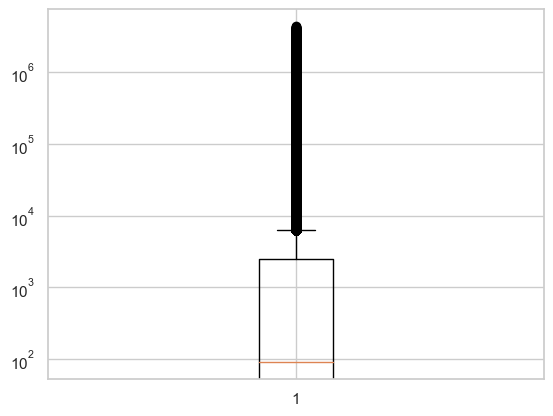

In [42]:
# Взявши колону Value, можемо побачити значу кількість викидів
plt.boxplot(DATAFRAME["Value"])
plt.yscale('log')
plt.show()

In [43]:
def validate_column(df: pd.DataFrame, column: str) -> None:
    """
    Check if the column is present in the data frame and if it is a numeric column.

    :param df: Input DataFrame.
    :param column: Input column name.
    :raises ValueError: If the column does not exist or is not numeric.
    """
    if column not in df.columns:
        raise ValueError(f'[!] Стовпець {column} не існує в DataFrame.')

    if not pd.api.types.is_numeric_dtype(df[column]):
        raise ValueError(f'[!] Стовпець {column} не є числовим.')

In [44]:
def iqr(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Видаляє викиди в обраному стовпці за допомогою методу IQR.

    :param df: Вхідний DataFrame.
    :param column: Назва стовпця для видалення викидів.
    :return: DataFrame без викидів.
    """
    validate_column(df, column)
    
    quantile_1: float = df[column].quantile(0.25)
    quantile_3: float = df[column].quantile(0.75)
    
    iqr_: float = quantile_3 - quantile_1

    lower_bound: float = quantile_1 - 1.5 * iqr_
    upper_bound: float = quantile_3 + 1.5 * iqr_

    initial_count: int = df.shape[0]

    clean_df: pd.DataFrame = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    final_count: int = clean_df.shape[0]
    print(f"[+] Видалено {initial_count - final_count} викидів за методом IQR | Стовпчик={column} | До={initial_count} Після={final_count}")

    return clean_df

In [45]:
# Очищення від викидів на прикладі колонки "Value"
# DATAFRAME = iqr(DATAFRAME, 'Value')

In [46]:
# Приклад очищення для усіх числових стовпчиків
def bulk_iqr(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove outliers from all numeric columns in the given DataFrame.
    :param df: Input DataFrame
    :return: Clean DataFrame 
    """
    num_cols = df.select_dtypes(include=['number']).columns
    
    for column in num_cols:
        print(f'[&] Removing outliers from {column}')
        df = iqr(df, column)
    return df

In [47]:
DATAFRAME = bulk_iqr(DATAFRAME)
CLEAN_DF = DATAFRAME.copy()

[&] Removing outliers from Port Code
[+] Видалено 54383 викидів за методом IQR | Стовпчик=Port Code | До=346733 Після=292350
[&] Removing outliers from Value
[+] Видалено 53694 викидів за методом IQR | Стовпчик=Value | До=292350 Після=238656


In [48]:
DATAFRAME.describe()

,Port Code,Value
count,238656.000000,238656.000000
mean,2955.467887,587.524990
std,683.818911,1222.146149
min,701.000000,0.000000
25%,2603.000000,0.000000
50%,3301.000000,12.000000
75%,3408.000000,480.000000
max,4105.000000,6562.000000


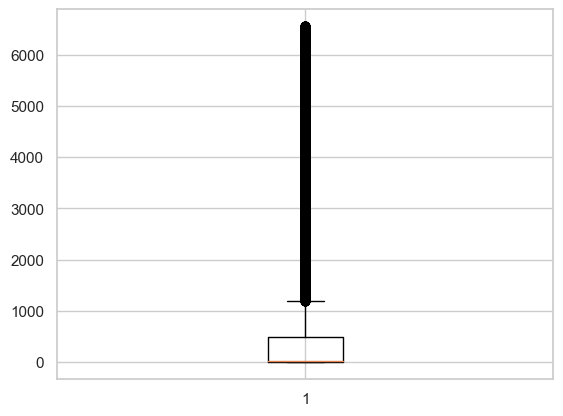

In [49]:
plt.boxplot(DATAFRAME["Value"])
plt.show()

## Розрахунок статистичних значень
Аналогічно створимо функцію ля отримання усієї інформації

In [50]:
def compute_statistics(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Обчислює статистичні показники для обраного стовпця.

    :param df: Вхідний DataFrame.
    :param column: Назва стовпця для обчислення статистики.
    :return: DataFrame з обчисленими показниками.
    """
    validate_column(df, column)

    mean_val: float = df[column].mean()
    trimmed_mean: float = stats.trim_mean(df[column], 0.05)
    median_val: float = df[column].median()
    variance: float = df[column].var()
    std_dev: float = df[column].std()
    
    mean_abs_deviation = np.mean(np.abs(df[column] - mean_val))
    median_abs_deviation = np.median(np.abs(df[column] - median_val))

    return pd.DataFrame({
        "Середнє": [mean_val],
        "Усічене середнє (5%)": [trimmed_mean],
        "Медіана": [median_val],
        "Дисперсія": [variance],
        "Стандартне відхилення": [std_dev],
        "Середнє абсолютне відхилення": [mean_abs_deviation],
        "Медіанне абсолютне відхилення": [median_abs_deviation],
    })

In [51]:
STATS_DF = compute_statistics(DATAFRAME, 'Value')
STATS_DF

,Середнє,Усічене середнє (5%),Медіана,Дисперсія,Стандартне відхилення,Середнє абсолютне відхилення,Медіанне абсолютне відхилення
0,587.52499,384.394307,12.0,1.493641e+06,1222.146149,807.574403,12.0


In [67]:
print(STATS_DF)

     Середнє  Усічене середнє (5%)  Медіана     Дисперсія  \
0  587.52499            384.394307     12.0  1.493641e+06   

   Стандартне відхилення  Середнє абсолютне відхилення  \
0            1222.146149                    807.574403   

   Медіанне абсолютне відхилення  
0                           12.0  


## Нормалізація

In [52]:
def min_max_normalization(df: pd.DataFrame, column: str, reassign: bool = False) -> pd.DataFrame:
    """
    Min-Max normalize given column in the DataFrame.
    
    :param df: Input DataFrame. 
    :param column: Input column name.
    :param reassign: Reassign new values to the column or create new?
    :return: DataFrame.
    """
    validate_column(df, column)

    min_val: float = df[column].min()
    max_val: float = df[column].max()

    value = (df[column] - min_val) / (max_val - min_val)

    if reassign:
        df[column] = value
    else:
        df[f'{column}_minmax'] = value

    print("Мін-Макс нормалізація виконана.")
    return df

In [53]:
DATAFRAME = min_max_normalization(DATAFRAME, 'Value', True)
DATAFRAME.head()

Мін-Макс нормалізація виконана.


,Port Name,State,Port Code,Border,Date,Measure,Value,Location
3,Nogales,Arizona,2604,US-Mexico Border,03/01/2019 12:00:00 AM,Trains,0.009448,POINT (-110.93361 31.340279999999996)
6,Pembina,North Dakota,3401,US-Canada Border,03/01/2019 12:00:00 AM,Bus Passengers,0.160622,POINT (-97.24333 48.96639)
7,Progreso,Texas,2309,US-Mexico Border,03/01/2019 12:00:00 AM,Truck Containers Empty,0.275526,POINT (-97.94889 26.061670000000003)
10,Opheim,Montana,3317,US-Canada Border,03/01/2019 12:00:00 AM,Personal Vehicles,0.035812,POINT (-106.40265 48.85574)
11,Neche,North Dakota,3404,US-Canada Border,03/01/2019 12:00:00 AM,Trucks,0.088997,POINT (-97.55444 48.98611)


In [54]:
def z_norm(df: pd.DataFrame, column: str, reassign: bool = False) -> pd.DataFrame:
    """
    Normalise a given column using the z-score method.
    
    :param df: Input DataFrame.
    :param column: Input column 
    :param reassign: Reassign new values to the column or create new?
    :return: Normalised DataFrame 
    """
    validate_column(df, column)
    
    mean_val: float = df[column].mean()
    std_dev: float = df[column].std()
    
    value = (df[column] - mean_val) / std_dev

    if reassign:
        df[column] = value
    else:
        df[f'{column}_zscore'] = value
    
    print("[+] Z-Score нормалізація виконана.")
    return df

In [55]:
DATAFRAME = z_norm(DATAFRAME, 'Value', True)
DATAFRAME.head()

[+] Z-Score нормалізація виконана.


,Port Name,State,Port Code,Border,Date,Measure,Value,Location
3,Nogales,Arizona,2604,US-Mexico Border,03/01/2019 12:00:00 AM,Trains,-0.430002,POINT (-110.93361 31.340279999999996)
6,Pembina,North Dakota,3401,US-Canada Border,03/01/2019 12:00:00 AM,Bus Passengers,0.381685,POINT (-97.24333 48.96639)
7,Progreso,Texas,2309,US-Mexico Border,03/01/2019 12:00:00 AM,Truck Containers Empty,0.998633,POINT (-97.94889 26.061670000000003)
10,Opheim,Montana,3317,US-Canada Border,03/01/2019 12:00:00 AM,Personal Vehicles,-0.288447,POINT (-106.40265 48.85574)
11,Neche,North Dakota,3404,US-Canada Border,03/01/2019 12:00:00 AM,Trucks,-0.002884,POINT (-97.55444 48.98611)


In [56]:
NORM_DF = DATAFRAME.copy()

## Візуалізація

In [57]:
def plot_histogram(df: pd.DataFrame, column: str) -> None:
    """
    Plot a histogram for a given column.

    :param df: Input DataFrame. 
    :param column: Input column. 
    :return: None 
    """
    validate_column(df, column)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Розподіл {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.tight_layout()

    plt.savefig(f'histogram_{column}.png')
    plt.show()

    print(f"[+] Гістограма збережена як 'histogram_{column}.png'")

In [58]:
def plot_boxplot(df: pd.DataFrame, column: str) -> None:
    """
    Plot a boxplot for a given column.

    :param df: Input DataFrame. 
    :param column: Input column. 
    :return: None 
    """
    validate_column(df, column)
    
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[column])

    plt.title(f'Boxplot {column}')
    plt.xlabel(column)
    plt.tight_layout()

    plt.savefig(f'boxplot_{column}.png')
    plt.show()

    print(f"[+] Boxplot збережено як 'boxplot_{column}.png'.")

In [59]:
def plot_scatter(df: pd.DataFrame, x_col: str, y_col: str) -> None:
    """
    Plot a scatterplot between two columns

    :param df: Input DataFrame. 
    :param x_col: Name of the column for the X-axis
    :param y_col: Name of the column for the Y-axis
    :return: None 
    """
    validate_column(df, x_col)
    validate_column(df, y_col)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df[x_col], y=df[y_col], alpha=0.5)

    plt.title(f'Зв\'язок між {x_col} та {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.tight_layout()

    name: str = f'{x_col}.{y_col}'

    plt.savefig(f'scatter_{name}.png')
    plt.show()

    print(f"[+] Boxplot збережено як 'boxplot_{name}.png'.")

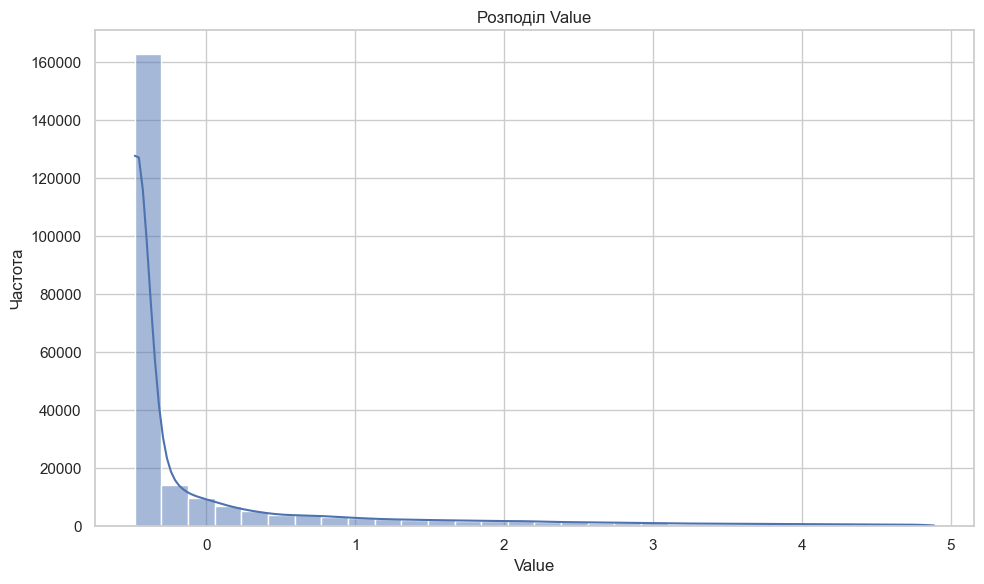

[+] Гістограма збережена як 'histogram_Value.png'


In [60]:
plot_histogram(DATAFRAME, 'Value')

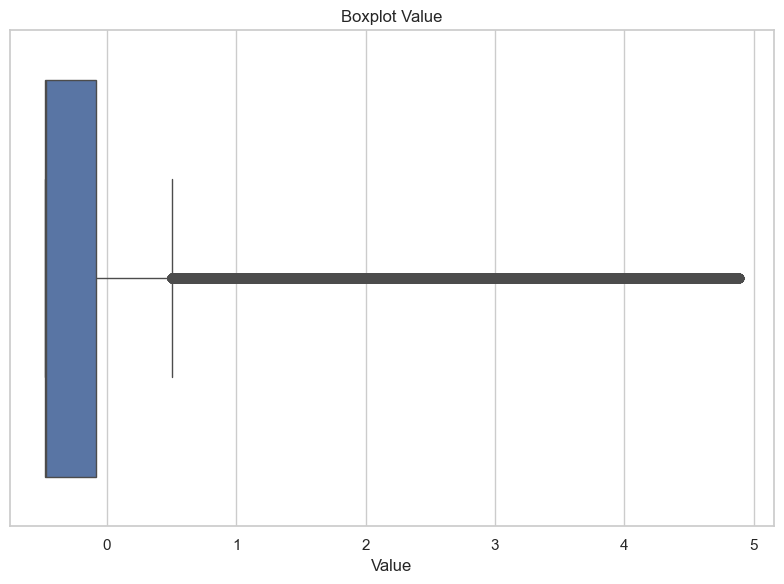

[+] Boxplot збережено як 'boxplot_Value.png'.


In [61]:
plot_boxplot(DATAFRAME, 'Value')

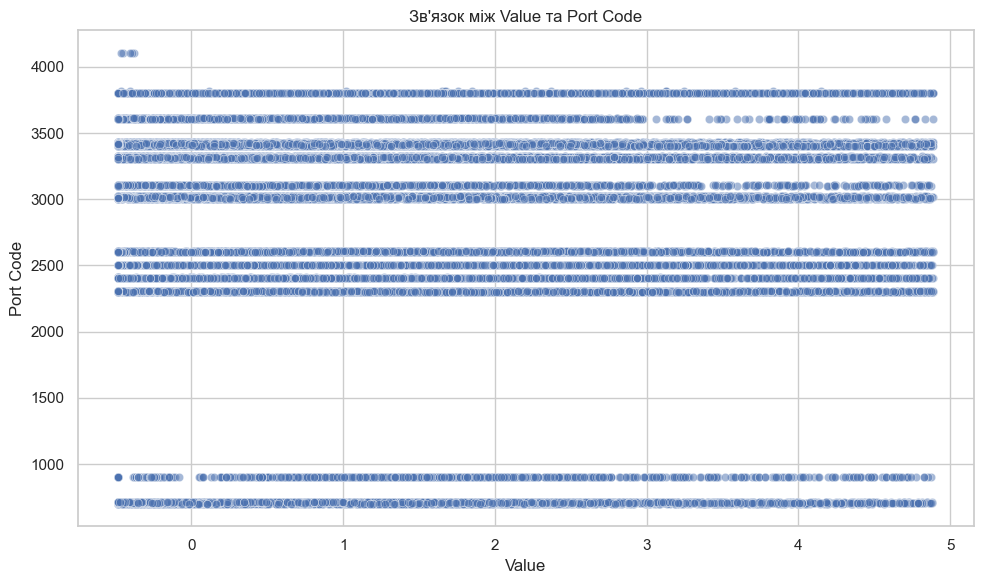

[+] Boxplot збережено як 'boxplot_Value.Port Code.png'.


In [62]:
plot_scatter(DATAFRAME, 'Value', 'Port Code')

In [63]:
def save_df(df: pd.DataFrame, filename: str) -> None:
    """
    Save a DataFrame to a file.
    :param df: Input DataFrame.
    :param filename: Name of the file to save the DataFrame to. 
    :return: None 
    """
    df.to_csv(filename, index=False)
    print(f'[+] Saved DataFrame to {filename}.')

In [64]:
save_df(STATS_DF, 'stats_value_df.csv')

[+] Saved DataFrame to stats_value_df.csv.


In [65]:
save_df(NORM_DF, 'norm_df.csv')

[+] Saved DataFrame to norm_df.csv.


In [66]:
save_df(DATAFRAME, 'final.csv')

[+] Saved DataFrame to final.csv.
